In [1]:
import logging
import shutil
import sys
import tempfile
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import nibabel as nib
import torch.nn as nn
import torch.nn.functional as F
import os.path as osp
import nibabel as nib
import monai.metrics as metrics
import sys
import pandas as pd
import random

sys.path.append('./..')

from glob import glob
from monai.networks.utils import one_hot
from utils.evaluation import data_prep, load_data, load_data_all
from utils.plotting import segmentation_visualization, segmentation_visualization_all
from utils.transforms import get_val_transforms, get_eval_post_transforms, get_train_transforms, get_infer_transforms
from utils.transforms import get_post_transforms
from utils.model import Normalizer
from pandas.plotting import parallel_coordinates
from utils.training import test_segmenter, test_NormSeg
from monai.data import Dataset, DataLoader, list_data_collate
from monai.networks.nets import DynUNet

In [2]:
# Setting
labels = {
            "vertical": 1,
            "superior longitudinal": 2,
            "inferior longitudinal": 3,
            "genioglossus": 4,
            "hyoglossus": 5,
            "background": 0,
        }

# Training data - BeLong T2w

In [ ]:
images, segmentations, predicted_segmentations = load_data('../predictions/BeLong_T2w/', ['../dataset/training/BeLong_T2w/'], 
                                                           ['segmenter_1000e_registered_BeLong'])

metrics_dict, files_list = data_prep('dice', images, segmentations, 
                        predicted_segmentations, dataset='train', labels = labels)


In [ ]:
import seaborn as sns
sns.violinplot(data = pd.DataFrame(metrics_dict), y='segmenter_1000e_registered_BeLong')
plt.ylim(0,1)

# Validation: Pre-trained model + TuneMod 
- proxy = ground-truth

## EATT T2w

### Exp 1

In [3]:
images, segmentations, predicted_segmentations = load_data('../predictions/EATT_T2w/', ['../dataset/test/EATT/T2w/'], 
                                                           ['segmenter_1000e_registered_BeLong', 
                                                            'tta/segmenter_1000e_registered_BeLong/100',
                                                            'tta/segmenter_1000e_registered_BeLong/200',
                                                            'tta/segmenter_1000e_registered_BeLong/300',
                                                            'tta/segmenter_1000e_registered_BeLong/400'])

metrics_dict, files_list = data_prep('dice', images, segmentations, 
                        predicted_segmentations, dataset='all', labels = labels)


In [4]:
df = pd.DataFrame(metrics_dict)
df.to_excel('../output/exp1_EATT_T2w_results.xlsx')

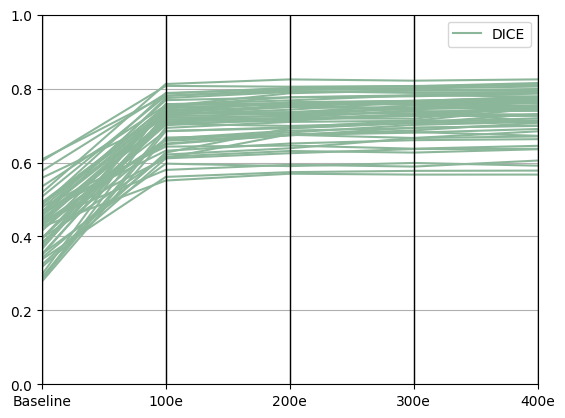

In [5]:

df = pd.read_excel('../output/exp1_EATT_T2w_results.xlsx')
df = df.drop(['Unnamed: 0'], axis =1)

df = df.rename(columns={"segmenter_1000e_registered_BeLong": "Baseline",
                   "tta_segmenter_1000e_registered_BeLong_100e": "100e",
                   "tta_segmenter_1000e_registered_BeLong_200e": "200e",
                   "tta_segmenter_1000e_registered_BeLong_300e": "300e",
                   "tta_segmenter_1000e_registered_BeLong_400e": "400e",
                   })

parallel_coordinates(df, 'Metric')
plt.ylim(0,1)
plt.show()


In [6]:
## Sub with no improvement in segmentation accuracy had a very blurry image.
segmentations[0][df[df["100e"]==df["100e"].min()].index[0]]

'../dataset/test/EATT/T2w/labels/sub-50_T2w_depadded_to_192_360_360.nii.gz'

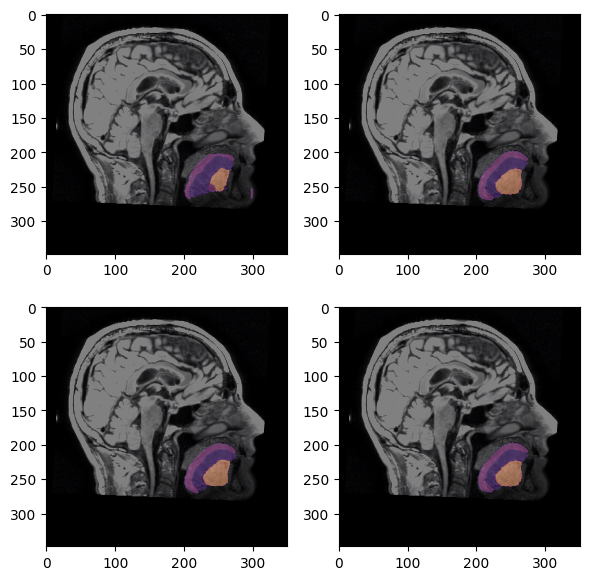

In [7]:
# Best accuracy
segmentation_visualization(files_list, n_predictions=2, index=df[df["100e"]==df["100e"].max()].index[0])

### Exp 2

In [8]:
n_participants = len(images[0])
indices_eatt = list(range(0, n_participants))
random.seed(5)
random.shuffle(indices_eatt)
# print(indices_eatt)

# Split dataset into 'training' and 'test' sets
training_set = indices_eatt[:int(n_participants*.8)]
test_set = indices_eatt[int(n_participants*.8):]

# Rank specific model performance 
best_model_performance = df['100e'][training_set].max()
worst_model_performance = df['100e'][training_set].min()
# print(best_model_performance)
index_best = df[df["100e"]==best_model_performance].index[0]
index_worst = df[df["100e"]==worst_model_performance].index[0]
# print(index_best)
print(images[0][index_best])
print(images[0][index_worst])

../dataset/test/EATT/T2w/images/sub-38_T2w_depadded_to_192_360_360.nii.gz
../dataset/test/EATT/T2w/images/sub-63_T2w_depadded_to_192_360_360.nii.gz


In [10]:
images, segmentations, predicted_segmentations = load_data('../predictions/EATT_T2w/', ['../dataset/test/EATT/T2w/'], 
                                                           ['segmenter_1000e_registered_BeLong', 
                                                            'tta/segmenter_1000e_registered_BeLong/100',
                                                            'tta/sub-38_T2w_depadded_/segmenter_1000e_registered_BeLong/100',
                                                            'tta/sub-63_T2w_depadded_/segmenter_1000e_registered_BeLong/100',
                                                            ])
images = np.array(images)[:, test_set]
segmentations = np.array(segmentations)[:, test_set]
predicted_segmentations = np.array(predicted_segmentations)[:, test_set]

In [11]:
metrics_dict, files_list = data_prep('dice', images, segmentations, 
                        predicted_segmentations, dataset='all', labels = labels)


df = pd.DataFrame(metrics_dict)
df.to_excel('../output/exp2_EATT_T2w_results.xlsx')

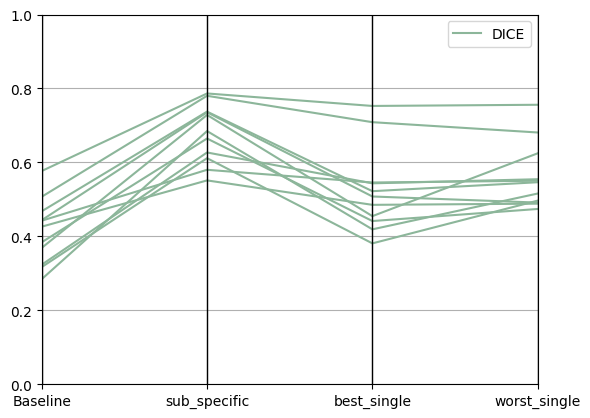

In [12]:
df = df.rename(columns={"segmenter_1000e_registered_BeLong": "Baseline",
                   "tta_segmenter_1000e_registered_BeLong_100e": "sub_specific",
                   "tta_sub-38_T2w_depadded__segmenter_1000e_registered_BeLonge": "best_single",
                   "tta_sub-63_T2w_depadded__segmenter_1000e_registered_BeLonge": "worst_single",
                   })
parallel_coordinates(df, 'Metric')
plt.ylim(0,1)
plt.show()

## BeLong T1w

### Exp 1

In [13]:
images, segmentations, predicted_segmentations = load_data('../predictions/BeLong_T1w/', ['../dataset/test/BeLong/T1w/'], 
                                                           ['segmenter_1000e_registered_BeLong', 
                                                            'tta/segmenter_1000e_registered_BeLong/100',
                                                            'tta/segmenter_1000e_registered_BeLong/200',
                                                            'tta/segmenter_1000e_registered_BeLong/300',
                                                            'tta/segmenter_1000e_registered_BeLong/400'])


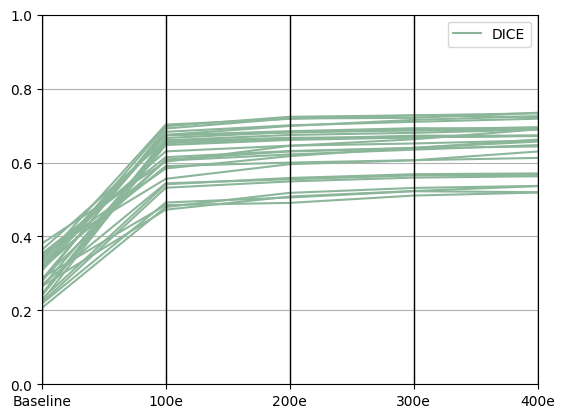

In [14]:
metrics_dict, files_list = data_prep('dice', images, segmentations, 
                        predicted_segmentations, dataset='all', labels = labels)


df = pd.DataFrame(metrics_dict)
df.to_excel('../output/exp1_BeLong_T1w_results.xlsx')
df = df.rename(columns={"segmenter_1000e_registered_BeLong": "Baseline",
                   "tta_segmenter_1000e_registered_BeLong_100e": "100e",
                   "tta_segmenter_1000e_registered_BeLong_200e": "200e",
                   "tta_segmenter_1000e_registered_BeLong_300e": "300e",
                   "tta_segmenter_1000e_registered_BeLong_400e": "400e",
                   })
parallel_coordinates(df, 'Metric')
plt.ylim(0,1)
plt.show()


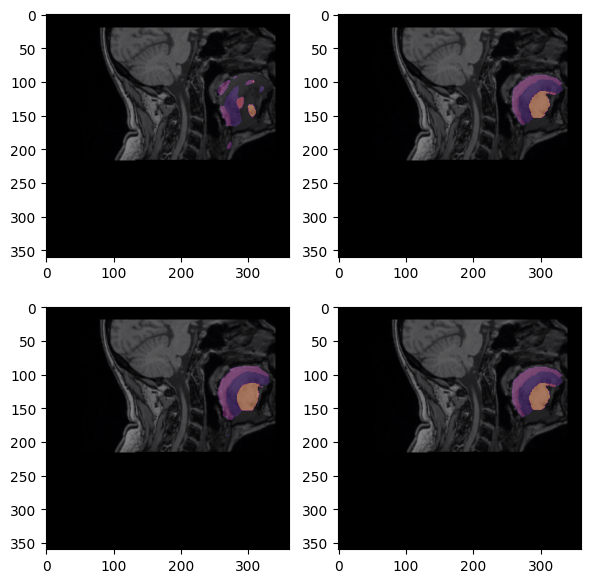

In [15]:
segmentation_visualization(files_list, n_predictions=2, index=df[df["100e"]==df["100e"].max()].index[0], save=True)

### Exp 2

In [16]:
n_participants = len(images[0])
indices_belong = list(range(0, n_participants))
random.seed(5)
random.shuffle(indices_belong)
# print(indices_belong)

# Split dataset into 'training' and 'test' sets
training_set = indices_belong[:int(n_participants*.8)]
test_set = indices_belong[int(n_participants*.8):]

# Rank specific model performance 
best_model_performance = df['100e'][training_set].max()
worst_model_performance = df['100e'][training_set].min()
# print(best_model_performance)
index_best = df[df["100e"]==best_model_performance].index[0]
index_worst = df[df["100e"]==worst_model_performance].index[0]
# print(index_best)
print(images[0][index_best])
print(images[0][index_worst])

../dataset/test/BeLong/T1w/images/sub-017_ses-01_T1w_padded_to_192_360_360.nii.gz
../dataset/test/BeLong/T1w/images/sub-032_ses-01_T1w_padded_to_192_360_360.nii.gz


In [17]:
images, segmentations, predicted_segmentations = load_data('../predictions/BeLong_T1w/', ['../dataset/test/BeLong/T1w/'], 
                                                           ['segmenter_1000e_registered_BeLong', 
                                                            'tta/segmenter_1000e_registered_BeLong/100',
                                                            'tta/sub-017_ses-01_T1w_p/segmenter_1000e_registered_BeLong/100',
                                                            'tta/sub-032_ses-01_T1w_p/segmenter_1000e_registered_BeLong/100',
                                                            ])
images = np.array(images)[:, test_set]
segmentations = np.array(segmentations)[:, test_set]
predicted_segmentations = np.array(predicted_segmentations)[:, test_set]

In [18]:
metrics_dict, files_list = data_prep('dice', images, segmentations, 
                        predicted_segmentations, dataset='all', labels = labels)


df = pd.DataFrame(metrics_dict)
df.to_excel('../output/exp2_BeLong_T1w_results.xlsx')

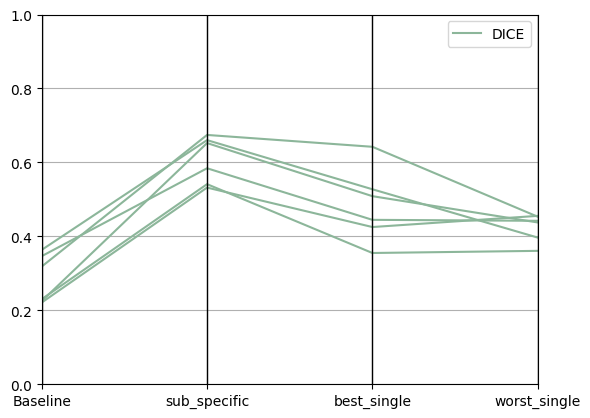

In [19]:
df = df.rename(columns={"segmenter_1000e_registered_BeLong": "Baseline",
                   "tta_segmenter_1000e_registered_BeLong_100e": "sub_specific",
                   "tta_sub-017_ses-01_T1w_p_segmenter_1000e_registered_BeLonge": "best_single",
                   "tta_sub-032_ses-01_T1w_p_segmenter_1000e_registered_BeLonge": "worst_single",
                   })
parallel_coordinates(df, 'Metric')
plt.ylim(0,1)
plt.show()

## Sydney T1w

##

### Exp 1

In [20]:
images, segmentations, predicted_segmentations = load_data('../predictions/Sydney_T1w/', ['../dataset/test/Sydney/T1w/'], 
                                                           ['segmenter_1000e_registered_BeLong', 
                                                            'tta/segmenter_1000e_registered_BeLong/100',
                                                            'tta/segmenter_1000e_registered_BeLong/200',
                                                            'tta/segmenter_1000e_registered_BeLong/300',
                                                            'tta/segmenter_1000e_registered_BeLong/400'])



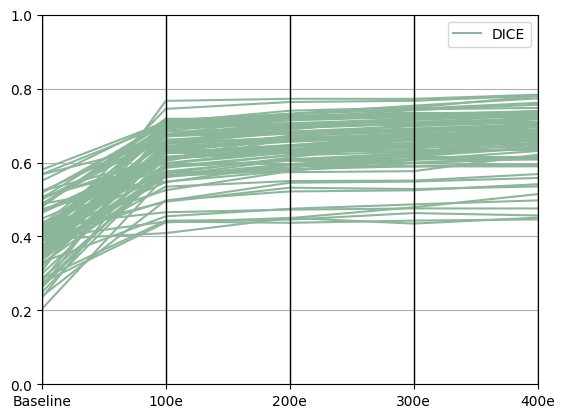

In [21]:
metrics_dict, files_list = data_prep('dice', images, segmentations, 
                        predicted_segmentations, dataset='all', labels = labels)


df = pd.DataFrame(metrics_dict)
df.to_excel('../output/exp1_Sydney_T1w_results.xlsx')
df = df.rename(columns={"segmenter_1000e_registered_BeLong": "Baseline",
                   "tta_segmenter_1000e_registered_BeLong_100e": "100e",
                   "tta_segmenter_1000e_registered_BeLong_200e": "200e",
                   "tta_segmenter_1000e_registered_BeLong_300e": "300e",
                   "tta_segmenter_1000e_registered_BeLong_400e": "400e",
                   })
parallel_coordinates(df, 'Metric')
plt.ylim(0,1)
plt.show()

In [ ]:
def segmentation_visualization(files, n_predictions, index, dataset='BeLong', save = False, tta_model = None):
    data = {}
    
    for i in range(n_predictions):
        data['prediction' + str(i + 1)] = nib.load(
            files['prediction' + str(i + 1)][index]).get_fdata()
        data['img' + str(i + 1)] = nib.load(
            files['img' + str(i + 1)][index]).get_fdata()
        data['groundtruth' + str(i + 1)] = nib.load(
            files['groundtruth' + str(i + 1)][index]).get_fdata()
    dataset = files['img' + str(i + 1)][index].split('/')
    fig, axs = plt.subplots(n_predictions, 2,
                            figsize=(3*n_predictions, 6))
    
    slice_index = 100
    if dataset == 'BeLong':
        slice_index = 50
    elif dataset == 'EATT' or dataset == 'Sydney':
        slice_index = 150
    print(slice_index)
    
    if n_predictions ==1:
            axs[0].imshow(
                np.rot90(data['img' + str(i + 1)][slice_index, :, :]), cmap='gray')
            axs[0].imshow(
                np.rot90(data['prediction' + str(i + 1)][slice_index, :, :]), cmap='magma', alpha=.5, vmax = 5)
            axs[1].imshow(
                np.rot90(data['img' + str(i + 1)][slice_index, :, :]), cmap='gray')
            axs[1].imshow(
                np.rot90(data['groundtruth' + str(i + 1)][slice_index, :, :]), cmap='magma', alpha=.5, vmax = 5)
    else:
        for i in range(n_predictions):
            axs[i, 0].imshow(
                np.rot90(data['img' + str(i + 1)][slice_index, :, :]), cmap='gray')
            axs[i, 0].imshow(
                np.rot90(data['prediction' + str(i + 1)][slice_index, :, :]), cmap='magma', alpha=.5, vmax = 5)
            axs[i, 1].imshow(
                np.rot90(data['img' + str(i + 1)][slice_index, :, :]), cmap='gray')
            axs[i, 1].imshow(
                np.rot90(data['groundtruth' + str(i + 1)][slice_index, :, :]), cmap='magma', alpha=.5, vmax = 5)
    

    plt.tight_layout()
    if save == True:
        if tta_model == None:
            directory = './QC/' + dataset[2] + '_' + dataset[3] + '/' 
        else:
            directory = './QC/' + dataset[2] + '_' + dataset[3] + '_' + tta_model + '/' 
        if not osp.exists(directory):
            os.makedirs(directory)
        plt.savefig(directory + dataset[5] + '.png', transparent = True,
                   bbox_inches = 'tight', dpi = 300)

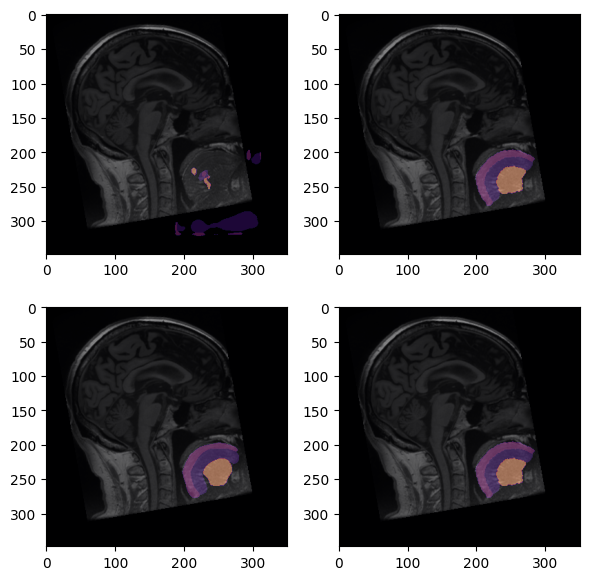

In [22]:
# Best accuracy

segmentation_visualization(files_list, n_predictions=2, index=df[df["100e"]==df["100e"].max()].index[0], save=True)

### Exp 2

In [23]:
n_participants = len(images[0])
indices_sydney = list(range(0, n_participants))
random.seed(5)
random.shuffle(indices_sydney)
# print(indices_sydney)

# Split dataset into 'training' and 'test' sets
training_set = indices_sydney[:int(n_participants*.8)]
test_set = indices_sydney[int(n_participants*.8):]

# Rank specific model performance 
best_model_performance = df['100e'][training_set].max()
worst_model_performance = df['100e'][training_set].min()
# print(best_model_performance)
index_best = df[df["100e"]==best_model_performance].index[0]
index_worst = df[df["100e"]==worst_model_performance].index[0]
# print(index_best)
print(images[0][index_best])
print(images[0][index_worst])

../dataset/test/Sydney/T1w/images/sub-109_T1w_depadded_to_192_360_360.nii.gz
../dataset/test/Sydney/T1w/images/sub-018_T1w_depadded_to_192_360_360.nii.gz


In [24]:
images, segmentations, predicted_segmentations = load_data('../predictions/Sydney_T1w/', ['../dataset/test/Sydney/T1w/'], 
                                                           ['segmenter_1000e_registered_BeLong', 
                                                            'tta/segmenter_1000e_registered_BeLong/100',
                                                            'tta/sub-109_T1w_depadded/segmenter_1000e_registered_BeLong/100',
                                                            'tta/sub-018_T1w_depadded/segmenter_1000e_registered_BeLong/100',
                                                            ])
images = np.array(images)[:, test_set]
segmentations = np.array(segmentations)[:, test_set]
predicted_segmentations = np.array(predicted_segmentations)[:, test_set]

In [25]:
metrics_dict, files_list = data_prep('dice', images, segmentations, 
                        predicted_segmentations, dataset='all', labels = labels)


df = pd.DataFrame(metrics_dict)
df.to_excel('../output/exp2_Sydney_T1w_results.xlsx')

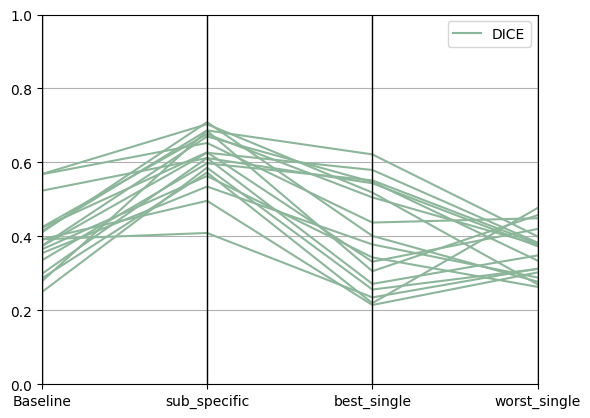

In [26]:
df = df.rename(columns={"segmenter_1000e_registered_BeLong": "Baseline",
                   "tta_segmenter_1000e_registered_BeLong_100e": "sub_specific",
                   "tta_sub-109_T1w_depadded_segmenter_1000e_registered_BeLonge": "best_single",
                   "tta_sub-018_T1w_depadded_segmenter_1000e_registered_BeLonge": "worst_single",
                   })
parallel_coordinates(df, 'Metric')
plt.ylim(0,1)
plt.show()